# Productive Stability Segmentation of Soybean Yield in Argentina

This notebook presents an unsupervised segmentation of Argentine soybean-producing departments based on yield stability metrics.  
The goal is to identify regions with different productive risk profiles, going beyond average production levels.


## Analytical Motivation

Average yield alone does not capture production risk in agriculture.  
Regions with similar average yields may exhibit very different levels of variability and reliability over time.

This analysis aims to answer:

- Which regions show stable and reliable soybean yields?
- Which regions are structurally volatile or risky?
- Can we group regions into meaningful stability profiles using historical data?


## Data Description

The dataset is based on official public data from [datos.gob.ar](https://www.datos.gob.ar/dataset/agroindustria-soja---siembra-cosecha-produccion-rendimiento) and contains annual soybean production records by department.

- Temporal coverage: 2004–2024 (in this case)
- Spatial unit: department_id
- Key variables:
  - Production (tons) (for performance)
  - Sown area (hectares) (for performance)
  - Yield (kg/ha)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv("soja_produccion_clean.csv")

df = df[(df["anio"] >= 2004) & (df["anio"] <= 2024)]
df.describe()

,anio,provincia_id,departamento_id,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tm,rendimiento_kgxha
count,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000,5.469000e+03,5469.000000
mean,2014.221796,34.999086,35201.901993,64630.768148,62615.368989,1.676592e+05,2399.752057
std,6.054495,31.521422,31403.105074,98474.876054,96588.221969,2.887151e+05,756.539301
min,2004.000000,6.000000,6007.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,2009.000000,6.000000,6630.000000,4000.000000,3600.000000,7.800000e+03,1900.000000
50%,2014.000000,22.000000,22056.000000,28800.000000,27600.000000,5.920000e+04,2500.000000
75%,2020.000000,66.000000,66112.000000,85000.000000,81700.000000,2.003660e+05,2958.000000
max,2024.000000,90.000000,90119.000000,894613.000000,883613.000000,2.637503e+06,3949.000000


## Methodological Approach

To characterize productive stability, the analysis focuses on variability-related indicators rather than production volume.

The segmentation is based on the following metrics computed at the department level:

1. Average yield (kg/ha)
2. Coefficient of variation (CV)
3. Average interannual yield volatility
4. Yield failure frequency (years below the department’s historical average)

These metrics capture both the level and the stability of agricultural performance.

## Feature Engineering

For each department, the selected indicators were computed over the 2004–2024 period.

- Yield was calculated as production per harvested area.
- Interannual volatility was measured as the absolute year-over-year change in yield.
- Yield failures were defined as years with yields below the department’s historical mean.


In [ ]:
avg_yield = (
    df.groupby("departamento_id")["rendimiento_kgxha"]
    .mean()
    .rename("avg_yield")
)

cv_yield = (
    df.groupby("departamento_id")["rendimiento_kgxha"]
    .std() /
    df.groupby("departamento_id")["rendimiento_kgxha"].mean()
    * 100
).rename("cv_yield")

df = df.sort_values(["departamento_id", "anio"])

df["delta_yield"] = (
    df.groupby("departamento_id")["rendimiento_kgxha"]
    .diff()
    .abs()
)

avg_volatility = (
    df.groupby("departamento_id")["delta_yield"]
    .mean()
    .rename("avg_volatility")
)

mean_yield_dep = df.groupby("departamento_id")["rendimiento_kgxha"].transform("mean")

df["falla"] = np.where(
    df["rendimiento_kgxha"] < mean_yield_dep,
    1,
    0
)

failure_rate = (
    df.groupby("departamento_id")["falla"]
    .mean()
    * 100
).rename("failure_rate")

## Clustering Dataset

The resulting dataset contains one row per department, summarizing its long-term productive behavior.

Each row represents a stable production unit suitable for unsupervised learning.

---
The number of clusters was evaluated using:

- The Elbow Method
- Silhouette Score

The selected number of clusters balances interpretability and clustering quality.

In [ ]:
cluster_df = pd.concat(
    [avg_yield, cv_yield, avg_volatility, failure_rate],
    axis=1
).dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

k_range = range(2, 7)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k} → silhouette={score:.3f}")

k=2 → silhouette=0.300
k=3 → silhouette=0.250
k=4 → silhouette=0.224
k=5 → silhouette=0.234
k=6 → silhouette=0.253


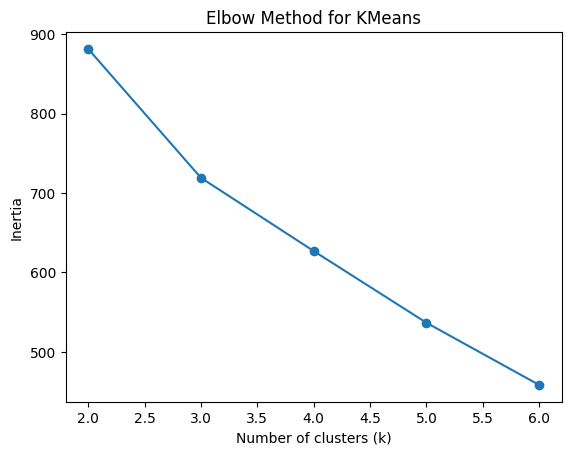

In [ ]:
plt.plot(list(k_range), inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()

## Clustering Results

K-Means clustering was applied to the standardized dataset, resulting in three distinct stability profiles.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_df["cluster"] = kmeans.fit_predict(X_scaled)

In [ ]:
cluster_summary = (
    cluster_df
    .groupby("cluster")
    .mean()
    .round(2)
)

print(cluster_summary)

         avg_yield  cv_yield  avg_volatility  failure_rate
cluster                                                   
0          1914.84     39.92          785.96         46.86
1          2679.97     22.78          640.07         37.31
2          2172.13     23.75          492.36         49.63


## Interpretation of Stability Profiles

The resulting clusters reveal meaningful differences in productive behavior:

- **High Stability / High Performance**  
  Departments with high average yields, low relative variability, and fewer yield failures.

- **Medium Stability / Structural Underperformance**  
  Departments with relatively stable yields, but frequently operating below their historical average.

- **Low Stability / High Risk**  
  Departments characterized by low yields, high volatility, and elevated production risk.

In [ ]:
cluster_labels = {
    0: "Low Stability / High Risk",
    1: "High Stability / High Performance",
    2: "Medium Stability / Structural Underperformance"
}
cluster_df["stability_profile"] = cluster_df["cluster"].map(cluster_labels)

## Validation and Limitations

The segmentation is data-driven and reflects historical patterns only.

Limitations include:
- Absence of climatic and soil variables
- Potential structural changes over time
- No causal inference

Despite these limitations, the clusters provide a robust exploratory framework for understanding regional production risk.


In [ ]:
cluster_df.reset_index().to_csv(
    "soja_stability_segmentation2.csv",
    index=False,
    encoding= 'utf-8'
)

## Integration with Tableau

The resulting stability profiles were exported and integrated into an interactive Tableau dashboard to facilitate spatial exploration and communication of results.


## Key Takeaways

- Productive stability varies significantly across regions, even among areas with similar average yields.
- Low volatility does not necessarily imply high performance.
- Stability-based segmentation provides a complementary perspective to traditional production analysis.
